# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [1]:
!pip install -q datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

## Last word prediction dataset 준비
- 기존의 IMDB dataset을 그대로 활용하고, collate_fn을 다음과 같이 수정
```
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-3])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels
```

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch.nn.utils.rnn import pad_sequence


# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]") # 전체 훈련 데이터의 5%만을 가져온다
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

tokenizer = torch.hub.load(
    'huggingface/pytorch-transformers', # Hugging Face의 pytorch-transformers 저장소
    'tokenizer', # 로드하려는 객체의 이름
    'bert-base-uncased' # 로드하려는 모델의 이름
)

token_list = tokenizer.get_vocab()
num_classes = len(token_list)

# 배치 단위로 데이터 전처리
def collate_fn(batch):
  max_len = 400 # 텍스트의 최대 길이 설정
  texts, labels = [], []
  for row in batch:
    texts.append(
      torch.LongTensor(
          tokenizer(row['text'],
          truncation=True,
          max_length=max_len
      ).input_ids[:-3]) # 각 토큰에 대응하는 고유한 ID
    )
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-3])

  texts = pad_sequence(
      texts,
      batch_first=True,
      padding_value=tokenizer.pad_token_id
  )
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Multi-head attention(MHA) 구현

- Self-attention module을 MHA로 확장해주시면 됩니다. 여기서 MHA는 다음과 같이 구현합니다.
  1. 기존의 $W_q, W_k, W_v$를 사용하여 $Q, K, V$를 생성합니다. 이 부분은 코드 수정이 필요 없습니다.
  2. $Q, K, V \in \mathbb{R}^{S \times D}$가 있을 때, 이를 $Q, K, V \in \mathbb{R}^{S \times H \times D’}$으로 reshape 해줍니다. 여기서 $H$는 `n_heads`라는 인자로 받아야 하고, $D$가 $H$로 나눠 떨어지는 값이여야 하는 제약 조건이 필요합니다. $D = H \times D’$입니다.
  3. $Q, K, V$를 $Q, K, V \in \mathbb{R}^{H \times S \times D’}$의 shape으로 transpose해줍니다.
  4. $A = QK^T/\sqrt{D'} \in \mathbb{R}^{H \times S \times S}$를 기존의 self-attention과 똑같이 계산합니다. 이 부분은 코드 수정이 필요 없습니다.
  5. Mask를 더합니다. 기존과 $A$의 shape이 달라졌기 때문에 dimension을 어떻게 맞춰줘야할지 생각해줘야 합니다.
  6. $\hat{x} = \textrm{Softmax}(A)V \in \mathbb{R}^{H \times S \times D'}$를 계산해주고 transpose와 reshape을 통해 $\hat{x} \in \mathbb{R}^{S \times D}$의 shape으로 다시 만들어줍니다.
  7. 기존과 똑같이 $\hat{x} = \hat{x} W_o$를 곱해줘서 마무리 해줍니다. 이 또한 코드 수정이 필요 없습니다.

In [3]:
from torch import nn
from math import sqrt


class MHA(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads

    self.wq = nn.Linear(input_dim, d_model) # query
    self.wk = nn.Linear(input_dim, d_model) # key
    self.wv = nn.Linear(input_dim, d_model) # value
    self.dense = nn.Linear(d_model, d_model) # 선형 변환

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x) # q: (B, S, D)
    B, S = q.shape[:2]
    D = self.d_model // self.n_heads

    for tensor in [q, k, v]:
      tensor = tensor.reshape((B, S, self.n_heads, D)).transpose(1,2)

    score = torch.matmul(q, k.transpose(-1, -2)) # (B, H, S, D) * (B, H, D, S) = (B, H, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9) # 마스크는 주로 불필요한 토큰(예: padding 토큰)을 무시

    score = self.softmax(score) # Attention 확률 분포(각 값들이 0과 1 사이로 변환되어, 전체 합이 1)
    result = torch.matmul(score, v) # (B, H, S, D)

    result = result.transpose(1, 2).reshape((B, S, -1))
    result = self.dense(result) # 최종 결과를 dense 레이어를 통과시켜서 d_model 차원으로 변환(결과의 차원을 일관되게 맞추기)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

## Layer normalization, dropout, residual connection 구현
```
# x, mask is given

x1 = MHA(x, mask)
x1 = Dropout(x1)
x1 = LayerNormalization(x1 + x)

x2 = FFN(x1)
x2 = Dropout(x2)
x2 = LayerNormalization(x2 + x1)

return x2
```
- 여기서 x1 + x와 x2 + x1에 해당하는 부분들은 residual connection이라고 부릅니다.


In [4]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, n_heads, dropout_rate=0.1):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff # Feed-Forward Network(FFN)에서의 숨겨진 레이어 차원입니다. FFN의 내부 구조에서 사용되는 차원
    self.n_heads = n_heads

    self.mha = MHA(input_dim, d_model, n_heads)
    self.ffn = nn.Sequential( # Feed-Forward Network
      nn.Linear(d_model, dff), # 차원 확장
      nn.ReLU(),
      nn.Linear(dff, d_model) # 차원 축소(기존 차원)
    )

    self.dropout = nn.Dropout(dropout_rate)
    self.layernorm1 = nn.LayerNorm(d_model)
    self.layernorm2 = nn.LayerNorm(d_model)

  def forward(self, x, mask):
    # Multi-Head Attention block
    x1 = self.mha(x, mask)
    x1 = self.dropout(x1)
    x1 = self.layernorm1(x1 + x) # Skip connection

    # Feed-Forward Network block
    x2 = self.ffn(x1)
    x2 = self.dropout(x2)
    x2 = self.layernorm2(x2 + x1) # Skip connection

    return x2

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [5]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [6]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, n_heads, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.n_heads = n_heads
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, num_classes) # 다중 클래스 분류

  def forward(self, x):
    seq_len = x.shape[1]
    mask = (x == tokenizer.pad_token_id)[..., None] # (B, S, 1)

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 5, 4, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습
### Loss function 및 classifier output 변경
- 마지막 token id를 예측하는 것이기 때문에 binary classification이 아닌 일반적인 classification 문제로 바뀝니다. MNIST 과제에서 했던 것 처럼 loss와 TextClassifier의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정하시면 됩니다.

### 학습 결과 report
- 기존 Transformer 실습에서 사용한 모델로 last word prediction을 학습하고 학습 경과를 report하면 됩니다.

In [7]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() # 다중 클래스 분류

optimizer = Adam(model.parameters(), lr=lr)

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # 다중 클래스 분류(가장 큰 확률을 가진 클래스를 예측하여 정확도를 계산)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Epoch   0 | Train Loss: 204.79384994506836
=========> Train acc: 0.035 | Test acc: 0.033


100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Epoch   1 | Train Loss: 186.80489444732666
=========> Train acc: 0.041 | Test acc: 0.039


100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


Epoch   2 | Train Loss: 167.44634580612183
=========> Train acc: 0.034 | Test acc: 0.034


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


Epoch   3 | Train Loss: 148.5197582244873
=========> Train acc: 0.034 | Test acc: 0.034


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch   4 | Train Loss: 133.28210830688477
=========> Train acc: 0.034 | Test acc: 0.031


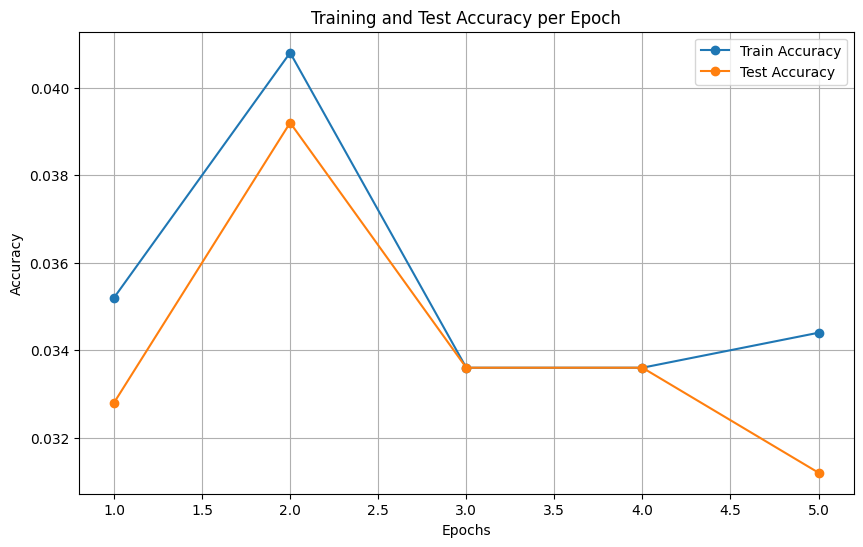

In [9]:
from tqdm import tqdm

n_epochs = 5

train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()

  for inputs, labels in tqdm(train_loader):
    model.zero_grad()
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long() # CrossEntropyLoss는 long 타입을 요구

    preds = model(inputs) # torch.Size([64, 1]): 2차원 텐서

    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

    # Append the accuracies for plotting
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting the training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()